In [1]:
import pandas as pd
import numpy as np
import math
import datetime
import matplotlib.pyplot as plt
from ipynb.fs.defs.functions import new_route
from ipynb.fs.defs.functions import get_row
from ipynb.fs.defs.functions import get_column
from ipynb.fs.defs.functions import best_index
from ipynb.fs.defs.functions import find_best_position
from ipynb.fs.defs.functions import cities_list
from ipynb.fs.defs.functions import getName
from ipynb.fs.defs.functions import check_cities
from ipynb.fs.defs.functions import timeDistance
from ipynb.fs.defs.functions import translate_name

dft = pd.read_csv("../distanze/corrected_times_computed.csv", delimiter=";", encoding = "ISO-8859-1", index_col=0)
dfd = pd.read_csv("../distanze/distances_computed.csv", delimiter=";", encoding = "ISO-8859-1", index_col=0)
times = []
kms = []
carico = []
wdays = []

In [21]:
def getTimeKm(df1, df2, missing):
    week = ["lunedi", "martedi", "mercoledi", "giovedi", "venerdi"]
    time = 0
    km = 0
    for day in week:
        if missing == True:
            time += round(timeDistance("Cremona, Sesto 39", df1[day][0], dft), 2)
            time += round(timeDistance(df1[day][len(df1[day].dropna())-1], "Ostiano, Mazzini, 1", dft), 2)
            km += round(timeDistance("Cremona, Sesto 39", df1[day][0], dfd), 2)
            km += round(timeDistance(df1[day][len(df1[day].dropna())-1], "Ostiano, Mazzini, 1", dfd), 2)
            
        time += round(sum(new_route(df1[day].dropna(), dft).values), 2)
        km += round(sum(new_route(df1[day].dropna(), dfd).values), 2)
        if day in df2.columns:
            if missing == True:
                time += round(timeDistance("Cremona, Sesto 39", df2[day][0], dft), 2)
                time += round(timeDistance(df2[day][len(df2[day].dropna())-1], "San Giovanni in Croce, Feudatari, 25 A", dft), 2)
                km += round(timeDistance("Cremona, Sesto 39", df2[day][0], dfd), 2)
                km += round(timeDistance(df2[day][len(df2[day].dropna())-1], "San Giovanni in Croce, Feudatari, 25 A", dfd), 2)
            
            time += round(sum(new_route(df2[day].dropna(), dft).values), 2)
            km += round(sum(new_route(df2[day].dropna(), dfd).values), 2)
            
    return round(time,2), round(km,2)

def getCarico(df1, df2, missing):
    sweek = ["martedi", "mercoledi", "giovedi"]
    total = 0
    diff_sum = 0
    a=0
    b=0
    for day in sweek:
        if missing == True:
            a = timeDistance("Cremona, Sesto 39", df1[day][0], dfd) + timeDistance(df1[day][len(df1[day].dropna())-1], "Ostiano, Mazzini, 1", dfd)
            total += a
            b = timeDistance("Cremona, Sesto 39", df2[day][0], dfd) + timeDistance(df2[day][len(df2[day].dropna())-1], "San Giovanni in Croce, Feudatari, 25 A", dfd)
            total += b
        total = total + sum(new_route(df1[day].dropna(), dfd).values) + sum(new_route(df2[day].dropna(), dfd).values)
        
        diff_sum = diff_sum + abs(sum(new_route(df1[day].dropna(), dfd).values)+a - sum(new_route(df2[day].dropna(), dfd).values)+b)
    return round(diff_sum/total, 2)

#Take schedulation and return a list that contains the day(in index) where the city appears
def getOccurenceDays(fur1, fur2, city, dframe, b):
    week = ["lunedi", "martedi", "mercoledi", "giovedi", "venerdi"]
    l = []
    for d in fur1.columns:
        if b == 1:
            cur_route1 = fur1[d].dropna()[1:len(fur1[d].dropna())-1]
        else:
            cur_route1 = fur1[d].dropna()
            
        if getName(dframe, city) in list(cur_route1):
            l.append(week.index(d))
            
    for d in fur2.columns:
        if b == 1:
            cur_route2 = fur2[d].dropna()[1:len(fur2[d].dropna())-1]
        else:
            cur_route2 = fur2[d].dropna()
            
        if getName(dframe, city) in list(cur_route2):
            l.append(week.index(d))
          
    return list(set(l))

def getDistance(s, e):
    if s == e:
        return 7
    if s < e:
        return e-s
    if s > e:
        return 7-(s-e)

"""def mean_wdays(fur1, fur2, city_s, city_e, dframe, b):
    s_list = getOccurenceDays(fur1, fur2, city_s, dframe, b)
    e_list = getOccurenceDays(fur1, fur2, city_e, dframe, b)
    results = []
    for s in s_list:
        for e in e_list:
            results.append(getDistance(s, e))
    
    if not results:
        return -1
    return round(sum(results) / len(results), 1)"""

def mean_wdays(fur1, fur2, city_s, city_e, dframe, b):
    s_list = getOccurenceDays(fur1, fur2, city_s, dframe, b)
    e_list = getOccurenceDays(fur1, fur2, city_e, dframe, b)
    results = []
    dists = []
    ocs = []
    for s in s_list:
        for e in e_list:
            results.append((s, e))
            dists.append(getDistance(s, e))
#         if not results:
#             #print(s_list, city_s, sep = ' $ ')
#             #print(e_list, city_e, sep = ' $ ')
#             return -1
    return dists

def compute_mean_wdays(dframe, fur1, fur2, b):
    #week = ["lunedi", "martedi", "mercoledi", "giovedi", "venerdi"]
    
    f1 = translate_name(dframe, fur1)
    f2 = translate_name(dframe, fur2)
    
    indx = [getName(dframe, x) for x in dframe.columns]
    #waiting_days = pd.DataFrame({}, index = indx, columns = indx)
    waiting_days = []
    for s in indx:
        for e in indx:
            res = mean_wdays(f1, f2, s, e, dframe, b)
            if res:
                waiting_days = waiting_days + res
            
            
    return round(sum(waiting_days)/len(waiting_days), 2)

## Original solution

In [22]:
df1 = pd.read_csv("../turni_f/original_start/f1_original.csv", delimiter=";", encoding = "ISO-8859-1")
df2 = pd.read_csv("../turni_f/original_start/f2_original.csv", delimiter=";", encoding = "ISO-8859-1")


print("Original")
time, km = getTimeKm(df1, df2, False)
times.append(time)
kms.append(km)
carico.append(getCarico(df1, df2, False))
print(f"Time: {times[-1]}  " +  
      f"Km: {kms[-1]}  " +
      f"Carico: {carico[-1]}  ")

print("\nOriginal Local Search")
df1 = pd.read_csv("../turni_f/original_start/original_ls1.csv", delimiter=";", encoding = "ISO-8859-1")
df2 = pd.read_csv("../turni_f/original_start/original_ls2.csv", delimiter=";", encoding = "ISO-8859-1")

time, km = getTimeKm(df1, df2, False)
times.append(time)
kms.append(km)
carico.append(getCarico(df1, df2, False))
print(f"Time: {times[-1]}  " +  
      f"Km: {kms[-1]}  " +
      f"Carico: {carico[-1]}  ")

print("\nOriginal 2-Opt")
df1 = pd.read_csv("../turni_f/original_start/original_2opt1.csv", delimiter=";", encoding = "ISO-8859-1")
df2 = pd.read_csv("../turni_f/original_start/original_2opt2.csv", delimiter=";", encoding = "ISO-8859-1")

time, km = getTimeKm(df1, df2, False)
times.append(time)
kms.append(km)
carico.append(getCarico(df1, df2, False))
print(f"Time: {times[-1]}  " +  
      f"Km: {kms[-1]}  " +
      f"Carico: {carico[-1]}  ")

print("\nOriginal Multi vehicle local search")
df1 = pd.read_csv("../turni_f/original_start/original_MVLS1.csv", delimiter=";", encoding = "ISO-8859-1")
df2 = pd.read_csv("../turni_f/original_start/original_MVLS2.csv", delimiter=";", encoding = "ISO-8859-1")

time, km = getTimeKm(df1, df2, False)
times.append(time)
kms.append(km)
carico.append(getCarico(df1, df2, False))
print(f"Time: {times[-1]}  " +  
      f"Km: {kms[-1]}  " 
      f"Carico: {carico[-1]}  ")


Original
Time: 1777.0  Km: 1691.0  Carico: 0.25  

Original Local Search
Time: 1568.0  Km: 1465.0  Carico: 0.18  

Original 2-Opt
Time: 1434.0  Km: 1309.0  Carico: 0.1  

Original Multi vehicle local search
Time: 1399.0  Km: 1218.0  Carico: 0.45  


## Random in-day

In [23]:
df1 = pd.read_csv("../turni_f/random_inday/random_day_f1.csv", delimiter=";", encoding = "ISO-8859-1")
df2 = pd.read_csv("../turni_f/random_inday/random_day_f2.csv", delimiter=";", encoding = "ISO-8859-1")


print("Random")
time, km = getTimeKm(df1, df2, False)
times.append(time)
kms.append(km)
carico.append(getCarico(df1, df2, False))
print(f"Time: {times[-1]}  " +  
      f"Km: {kms[-1]}  " +
      f"Carico: {carico[-1]}  ")

print("\nRandom Local Search")
df1 = pd.read_csv("../turni_f/random_inday/random_day_ls_f1.csv", delimiter=";", encoding = "ISO-8859-1")
df2 = pd.read_csv("../turni_f/random_inday/random_day_ls_f2.csv", delimiter=";", encoding = "ISO-8859-1")

time, km = getTimeKm(df1, df2, False)
times.append(time)
kms.append(km)
carico.append(getCarico(df1, df2, False))
print(f"Time: {times[-1]}  " +  
      f"Km: {kms[-1]}  " +
      f"Carico: {carico[-1]}  ")

print("\nRandom 2-Opt")
df1 = pd.read_csv("../turni_f/random_inday/random_day_2opt_f1.csv", delimiter=";", encoding = "ISO-8859-1")
df2 = pd.read_csv("../turni_f/random_inday/random_day_2opt_f2.csv", delimiter=";", encoding = "ISO-8859-1")

time, km = getTimeKm(df1, df2, False)
times.append(time)
kms.append(km)
carico.append(getCarico(df1, df2, False))
print(f"Time: {times[-1]}  " +  
      f"Km: {kms[-1]}  " +
      f"Carico: {carico[-1]}  ")

print("\nRandom Multi vehicle local search")
df1 = pd.read_csv("../turni_f/random_inday/random_day_MVLS_f1.csv", delimiter=";", encoding = "ISO-8859-1")
df2 = pd.read_csv("../turni_f/random_inday/random_day_MVLS_f2.csv", delimiter=";", encoding = "ISO-8859-1")

time, km = getTimeKm(df1, df2, False)
times.append(time)
kms.append(km)
carico.append(getCarico(df1, df2, False))
print(f"Time: {times[-1]}  " +  
      f"Km: {kms[-1]}  " 
      f"Carico: {carico[-1]}  ")


Random
Time: 2610.0  Km: 2615.0  Carico: 0.22  

Random Local Search
Time: 1608.0  Km: 1566.0  Carico: 0.18  

Random 2-Opt
Time: 1517.0  Km: 1461.0  Carico: 0.18  

Random Multi vehicle local search
Time: 1364.0  Km: 1212.0  Carico: 0.41  


## Greedy

In [24]:
df1 = pd.read_csv("../turni_f/furgoncino1_routing.csv", delimiter=";", encoding = "ISO-8859-1")
df2 = pd.read_csv("../turni_f/furgoncino2_routing.csv", delimiter=";", encoding = "ISO-8859-1")


print("Greedy")
time, km = getTimeKm(df1, df2, False)
times.append(time)
kms.append(km)
carico.append(getCarico(df1, df2, False))
print(f"Time: {times[-1]}  " +  
      f"Km: {kms[-1]}  " +
      f"Carico: {carico[-1]}  ")

print("\nGreedy Local Search")
df1 = pd.read_csv("../turni_f/ls1_shifts.csv", delimiter=";", encoding = "ISO-8859-1")
df2 = pd.read_csv("../turni_f/ls2_shifts.csv", delimiter=";", encoding = "ISO-8859-1")

time, km = getTimeKm(df1, df2, False)
times.append(time)
kms.append(km)
carico.append(getCarico(df1, df2, False))
print(f"Time: {times[-1]}  " +  
      f"Km: {kms[-1]}  " +
      f"Carico: {carico[-1]}  ")

print("\nGreedy 2-Opt")
df1 = pd.read_csv("../turni_f/2-opt1_shifts.csv", delimiter=";", encoding = "ISO-8859-1")
df2 = pd.read_csv("../turni_f/2-opt2_shifts.csv", delimiter=";", encoding = "ISO-8859-1")

time, km = getTimeKm(df1, df2, False)
times.append(time)
kms.append(km)
carico.append(getCarico(df1, df2, False))
print(f"Time: {times[-1]}  " +  
      f"Km: {kms[-1]}  " +
      f"Carico: {carico[-1]}  ")

print("\nGreedy Multi vehicle local search")
df1 = pd.read_csv("../turni_f/MVLS1.csv", delimiter=";", encoding = "ISO-8859-1")
df2 = pd.read_csv("../turni_f/MVLS2.csv", delimiter=";", encoding = "ISO-8859-1")

time, km = getTimeKm(df1, df2, False)
times.append(time)
kms.append(km)
carico.append(getCarico(df1, df2, False))
print(f"Time: {times[-1]}  " +  
      f"Km: {kms[-1]}  " +
      f"Carico: {carico[-1]}  ")


Greedy
Time: 1432.0  Km: 1304.0  Carico: 0.3  

Greedy Local Search
Time: 1378.0  Km: 1268.0  Carico: 0.3  

Greedy 2-Opt
Time: 1315.0  Km: 1222.0  Carico: 0.33  

Greedy Multi vehicle local search
Time: 1378.0  Km: 1262.0  Carico: 0.56  


## Optimized Start Schedule

In [25]:
df1 = pd.read_csv("../turni_f/optimized_start/oss_greedy1.csv", delimiter=";", encoding = "ISO-8859-1")
df2 = pd.read_csv("../turni_f/optimized_start/oss_greedy2.csv", delimiter=";", encoding = "ISO-8859-1")


print("OSS greedy")
time, km = getTimeKm(df1, df2, False)
times.append(time)
kms.append(km)
carico.append(getCarico(df1, df2, False))
print(f"Time: {times[-1]}  " +  
      f"Km: {kms[-1]}  " +
      f"Carico: {carico[-1]}  ")

print("\nOSS Local Search")
df1 = pd.read_csv("../turni_f/optimized_start/oss_ls1.csv", delimiter=";", encoding = "ISO-8859-1")
df2 = pd.read_csv("../turni_f/optimized_start/oss_ls2.csv", delimiter=";", encoding = "ISO-8859-1")

time, km = getTimeKm(df1, df2, False)
times.append(time)
kms.append(km)
carico.append(getCarico(df1, df2, False))
print(f"Time: {times[-1]}  " +  
      f"Km: {kms[-1]}  " +
      f"Carico: {carico[-1]}  ")

print("\nOSS 2-Opt")
df1 = pd.read_csv("../turni_f/optimized_start/oss_2opt_f1.csv", delimiter=";", encoding = "ISO-8859-1")
df2 = pd.read_csv("../turni_f/optimized_start/oss_2opt_f2.csv", delimiter=";", encoding = "ISO-8859-1")

time, km = getTimeKm(df1, df2, False)
times.append(time)
kms.append(km)
carico.append(getCarico(df1, df2, False))
print(f"Time: {times[-1]}  " +  
      f"Km: {kms[-1]}  " +
      f"Carico: {carico[-1]}  ")

print("\nOSS Multi vehicle local search")
df1 = pd.read_csv("../turni_f/optimized_start/oss_MVLS_f1.csv", delimiter=";", encoding = "ISO-8859-1")
df2 = pd.read_csv("../turni_f/optimized_start/oss_MVLS_f2.csv", delimiter=";", encoding = "ISO-8859-1")

time, km = getTimeKm(df1, df2, False)
times.append(time)
kms.append(km)
carico.append(getCarico(df1, df2, False))
print(f"Time: {times[-1]}  " +  
      f"Km: {kms[-1]}  " +
      f"Carico: {carico[-1]}  ")

OSS greedy
Time: 1687.0  Km: 1612.0  Carico: 0.25  

OSS Local Search
Time: 1636.0  Km: 1555.0  Carico: 0.24  

OSS 2-Opt
Time: 1475.0  Km: 1341.0  Carico: 0.19  

OSS Multi vehicle local search
Time: 1635.0  Km: 1528.0  Carico: 0.63  


## Fine Optimized Schedule Start

In [26]:
df1 = pd.read_csv("../turni_f/fine_optimized_start/foss_greedy1.csv", delimiter=";", encoding = "ISO-8859-1")
df2 = pd.read_csv("../turni_f/fine_optimized_start/foss_greedy2.csv", delimiter=";", encoding = "ISO-8859-1")


print("FOSS greedy")
time, km = getTimeKm(df1, df2, False)
times.append(time)
kms.append(km)
carico.append(getCarico(df1, df2, False))
print(f"Time: {times[-1]}  " +  
      f"Km: {kms[-1]}  " +
      f"Carico: {carico[-1]}  ")

print("\nFOSS Local Search")
df1 = pd.read_csv("../turni_f/fine_optimized_start/foss_ls1.csv", delimiter=";", encoding = "ISO-8859-1")
df2 = pd.read_csv("../turni_f/fine_optimized_start/foss_ls2.csv", delimiter=";", encoding = "ISO-8859-1")

time, km = getTimeKm(df1, df2, False)
times.append(time)
kms.append(km)
carico.append(getCarico(df1, df2, False))
print(f"Time: {times[-1]}  " +  
      f"Km: {kms[-1]}  " +
      f"Carico: {carico[-1]}  ")

print("\nFOSS 2-Opt")
df1 = pd.read_csv("../turni_f/fine_optimized_start/foss_2opt1.csv", delimiter=";", encoding = "ISO-8859-1")
df2 = pd.read_csv("../turni_f/fine_optimized_start/foss_2opt2.csv", delimiter=";", encoding = "ISO-8859-1")

time, km = getTimeKm(df1, df2, False)
times.append(time)
kms.append(km)
carico.append(getCarico(df1, df2, False))
print(f"Time: {times[-1]}  " +  
      f"Km: {kms[-1]}  " +
      f"Carico: {carico[-1]}  ")

print("\nFOSS Multi vehicle local search")
df1 = pd.read_csv("../turni_f/fine_optimized_start/foss_MVLS1.csv", delimiter=";", encoding = "ISO-8859-1")
df2 = pd.read_csv("../turni_f/fine_optimized_start/foss_MVLS2.csv", delimiter=";", encoding = "ISO-8859-1")

time, km = getTimeKm(df1, df2, False)
times.append(time)
kms.append(km)
carico.append(getCarico(df1, df2, False))
print(f"Time: {times[-1]}  " +  
      f"Km: {kms[-1]}  " +
      f"Carico: {carico[-1]}  ")

FOSS greedy
Time: 1602.0  Km: 1485.0  Carico: 0.37  

FOSS Local Search
Time: 1582.0  Km: 1477.0  Carico: 0.37  

FOSS 2-Opt
Time: 1443.0  Km: 1328.0  Carico: 0.31  

FOSS Multi vehicle local search
Time: 1392.0  Km: 1247.0  Carico: 0.48  


## Random schedule

In [28]:
df1 = pd.read_csv("../turni_f/random_schedule/random_greedy_f1.csv", delimiter=";", encoding = "ISO-8859-1")
df2 = pd.read_csv("../turni_f/random_schedule/random_greedy_f2.csv", delimiter=";", encoding = "ISO-8859-1")


print("Random schedule")
time, km = getTimeKm(df1, df2, False)
times.append(time)
kms.append(km)
carico.append(getCarico(df1, df2, False))
print(f"Time: {times[-1]}  " +  
      f"Km: {kms[-1]}  " +
      f"Carico: {carico[-1]}  ")

print("\nRandom schedule Local Search")
df1 = pd.read_csv("../turni_f/random_schedule/random_ls_f1.csv", delimiter=";", encoding = "ISO-8859-1")
df2 = pd.read_csv("../turni_f/random_schedule/random_ls_f2.csv", delimiter=";", encoding = "ISO-8859-1")

time, km = getTimeKm(df1, df2, False)
times.append(time)
kms.append(km)
carico.append(getCarico(df1, df2, False))
print(f"Time: {times[-1]}  " +  
      f"Km: {kms[-1]}  " +
      f"Carico: {carico[-1]}  ")

print("\nRandom schedule 2-Opt")
df1 = pd.read_csv("../turni_f/random_schedule/random_2opt_f1.csv", delimiter=";", encoding = "ISO-8859-1")
df2 = pd.read_csv("../turni_f/random_schedule/random_2opt_f2.csv", delimiter=";", encoding = "ISO-8859-1")

time, km = getTimeKm(df1, df2, False)
times.append(time)
kms.append(km)
carico.append(getCarico(df1, df2, False))
print(f"Time: {times[-1]}  " +  
      f"Km: {kms[-1]}  " +
      f"Carico: {carico[-1]}  ")

print("\nRandom schedule Multi vehicle local search")
df1 = pd.read_csv("../turni_f/random_schedule/random_MVLS_f1.csv", delimiter=";", encoding = "ISO-8859-1")
df2 = pd.read_csv("../turni_f/random_schedule/random_MVLS_f2.csv", delimiter=";", encoding = "ISO-8859-1")

time, km = getTimeKm(df1, df2, False)
times.append(time)
kms.append(km)
carico.append(getCarico(df1, df2, False))
print(f"Time: {times[-1]}  " +  
      f"Km: {kms[-1]}  " 
      f"Carico: {carico[-1]}  ")


Random schedule
Time: 1869.0  Km: 1798.0  Carico: 0.17  

Random schedule Local Search
Time: 1746.0  Km: 1685.0  Carico: 0.22  

Random schedule 2-Opt
Time: 1643.0  Km: 1545.0  Carico: 0.22  

Random schedule Multi vehicle local search
Time: 1419.0  Km: 1262.0  Carico: 0.35  


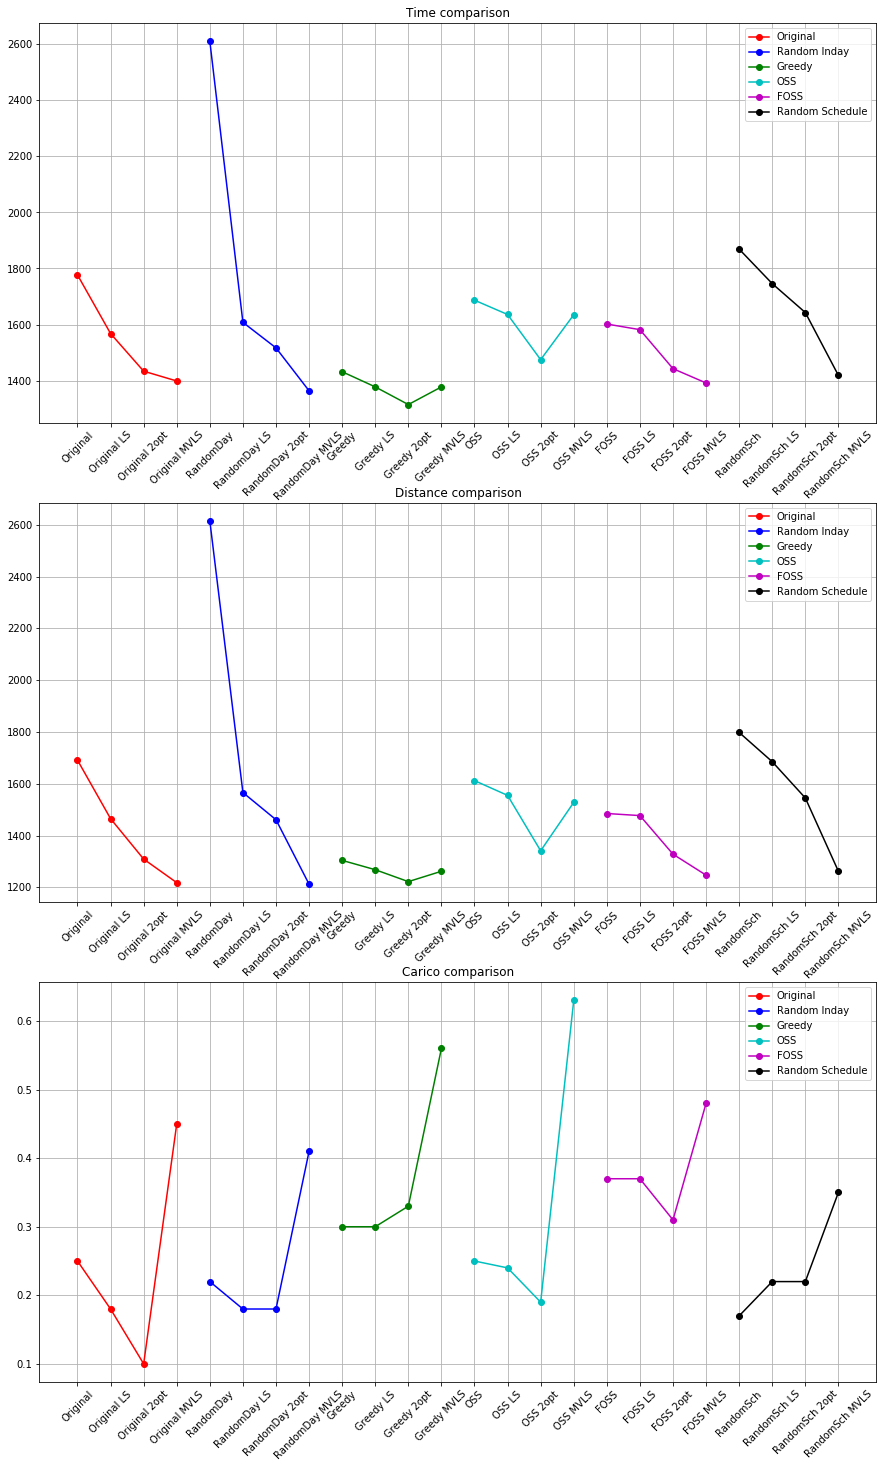

In [31]:
names = ["Original", "Original LS", "Original 2opt", "Original MVLS",
         "RandomDay", "RandomDay LS", "RandomDay 2opt", "RandomDay MVLS",
         "Greedy", "Greedy LS", "Greedy 2opt", "Greedy MVLS",
         "OSS", "OSS LS", "OSS 2opt", "OSS MVLS", 
         "FOSS", "FOSS LS", "FOSS 2opt","FOSS MVLS",
         "RandomSch", "RandomSch LS", "RandomSch 2opt", "RandomSch MVLS"]
colors = ["r","b","g","c","m","k"]
plt.figure(figsize=[15,25])
plt.subplot(311)
plt.grid()
for i in range(len(colors)):
    plt.plot(names[i*4:i*4+4], times[i*4:i*4+4], colors[i]+"o-")
plt.legend(["Original", "Random Inday", "Greedy", "OSS", "FOSS", "Random Schedule"])
plt.xticks(rotation=45)
plt.title("Time comparison")

plt.subplot(312)
plt.grid()
for i in range(len(colors)):
    plt.plot(names[i*4:i*4+4], kms[i*4:i*4+4], colors[i]+"o-")
plt.legend(["Original", "Random Inday", "Greedy", "OSS", "FOSS", "Random Schedule"])
plt.xticks(rotation=45)
plt.title("Distance comparison")

plt.subplot(313)
plt.grid()
for i in range(len(colors)):
    plt.plot(names[i*4:i*4+4], carico[i*4:i*4+4], colors[i]+"o-")
plt.legend(["Original", "Random Inday", "Greedy", "OSS", "FOSS", "Random Schedule"])
plt.xticks(rotation=45)
plt.title("Carico comparison")

plt.show()
#plt.savefig('compare_results_FOSS.png')

[3, 10, 14, 16] [0.016, 0.069, 0.249, 0.2385]
[7, 8, 11, 16] [0.348, 0.62, 0.0, 1.995]
[9, 10, 13, 18] [3.228, 4.418, 9.742, 26.243000000000002]
[3, 10, 14, 16] [0.016, 0.069, 0.249, 0.2385]
[2, 10, 16, 17] [0.0, 0.0, 1.521, 0.0]
[2, 10, 16, 17] [0.03, 4.692, 22.807499999999997, 23.985]


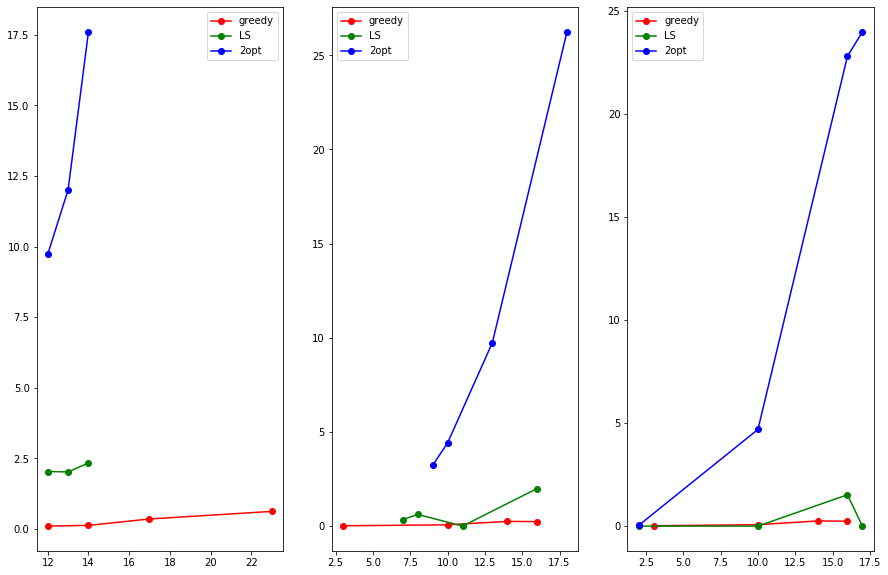

In [8]:
results = pd.read_csv("../altro/computational_times.csv", delimiter=";", encoding = "ISO-8859-1", index_col=0)
colors = ["r","b","g","c","m","k"]
i=0
plt.figure(figsize=[15,10])
plt.subplot(131)
for k in range(len(results[:len(results)-1])):
    row = results.iloc[k]
    y = [float(el.split(",")[0].strip()[1:]) for el in row]
    x = [int(el.split(",")[1].strip()) for el in row]
    to_plot = pd.Series(data=y, index=x).sort_index()
    
    color = "o-"+c[i]
    i += 1
    x = list(set(x))
    x.sort()
    y = [to_plot[qua].mean() for qua in x]
    plt.plot(x, y, color)
    plt.legend(results.index)
results = pd.read_csv("../altro/computational_times_OSS.csv", delimiter=";", encoding = "ISO-8859-1", index_col=0)
c=["r","g","b","k"]
i=0
plt.subplot(132)
for k in range(len(results[:len(results)])):
    row = results.iloc[k]
    y = [float(el.split(",")[0].strip()[1:]) for el in row]
    x = [int(el.split(",")[1].strip()) for el in row]
    to_plot = pd.Series(data=y, index=x).sort_index()
    
    color = "o-"+c[i]
    i += 1
    x = list(set(x))
    x.sort()
    y = [to_plot[qua].mean() for qua in x]
    plt.plot(x, y, color)
    print(x,y)
    plt.legend(results.index)
results = pd.read_csv("../altro/computational_times_FOSS.csv", delimiter=";", encoding = "ISO-8859-1", index_col=0)
c=["r","g","b","k"]
i=0
plt.subplot(133)
for k in range(len(results[:len(results)])):
    row = results.iloc[k]
    y = [float(el.split(",")[0].strip()[1:]) for el in row]
    x = [int(el.split(",")[1].strip()) for el in row]
    to_plot = pd.Series(data=y, index=x).sort_index()
    
    color = "o-"+c[i]
    i += 1
    x = list(set(x))
    x.sort()
    y = [to_plot[qua].mean() for qua in x]
    plt.plot(x, y, color)
    print(x,y)
    plt.legend(results.index)
plt.show()